In [1]:
import torch
import triton 
import triton.language as tl
from mla_triton import triton_mla
torch.cuda.empty_cache()

# triton benchmark

In [2]:
def torch_mla(qk_merge, compress_kv, v_weight, q_rope, k_rope, scale, v_head_dim, attention_mask=None, golden=False):
    if golden:
        dtype = torch.float32
        qk_merge = qk_merge.to(dtype)
        compress_kv = compress_kv.to(dtype)
        v_weight = v_weight.to(dtype)
        q_rope = q_rope.to(dtype)
        k_rope = k_rope.to(dtype)
    device = k_rope.device
    dtype = k_rope.dtype
    q_len = qk_merge.shape[-2]
    kv_len = k_rope.shape[-2]
    min_value = torch.finfo(dtype).min
    score1 = qk_merge @ compress_kv.unsqueeze(1).transpose(-1,-2)
    score2 = q_rope @ k_rope.transpose(-1,-2)
    if q_len > 1: # prefill
        causal_mask:torch.tensor = torch.full((q_len, kv_len), min_value, dtype=dtype, device=device).triu(diagonal=1)
        causal_mask = causal_mask[None, None, :, :].expand(q_rope.shape[0], -1, -1, -1)
        if attention_mask is not None:
            causal_mask:torch.tensor = causal_mask.masked_fill((1-attention_mask[:, None, None, :]).bool(), min_value)
    else: # decode
        if attention_mask is None:
            causal_mask = 0
        else:
            causal_mask = torch.zeros_like(attention_mask).masked_fill((1-attention_mask).bool(), min_value)
            causal_mask = causal_mask[:, None, None, :]
    score = (score1 + score2) * scale + causal_mask
    attn_weight = torch.nn.functional.softmax(score, dim=-1, dtype=torch.float32).to(dtype)
    o = attn_weight @ compress_kv.unsqueeze(1)
    v_weight = v_weight.view(-1, v_head_dim, qk_merge.shape[-1]).unsqueeze(0) 
    o = o @ v_weight.transpose(-1, -2)
    return o

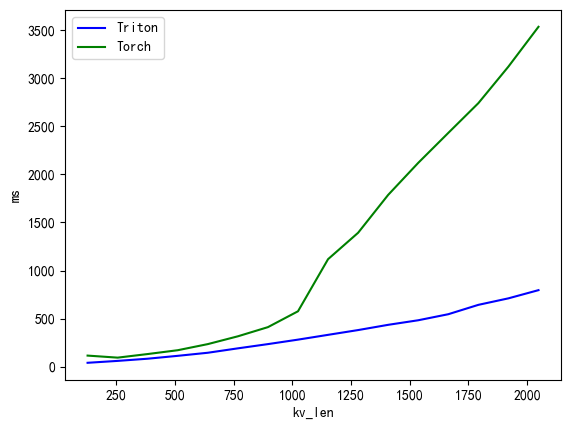

q_len = kv_len: prefill:
    kv_len      Triton        Torch
0    128.0   40.347002   115.275167
1    256.0   60.131874    93.988962
2    384.0   82.869098   131.452322
3    512.0  112.844273   171.279743
4    640.0  144.848585   234.813690
5    768.0  190.692484   315.986037
6    896.0  234.784499   411.332816
7   1024.0  281.335682   576.373339
8   1152.0  331.157714  1118.415713
9   1280.0  380.863696  1393.119216
10  1408.0  435.399860  1787.351251
11  1536.0  482.876182  2120.450497
12  1664.0  545.804322  2432.038784
13  1792.0  643.190622  2741.557121
14  1920.0  710.895598  3121.858358
15  2048.0  796.107590  3535.887241


In [3]:
device = torch.device('cuda')
dtype = torch.float16
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['kv_len'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="q_len = kv_len: prefill",  # name for the plot. Used also as a file name for saving the plot.
        args={'bs': 1, 'num_head': 8, 'rope_head_dim': 32, 
              'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(kv_len, provider, bs, num_head, rope_head_dim, nope_head_dim, kv_lora_rank):
    q_len = kv_len
    v_head_dim = nope_head_dim
    scale = (rope_head_dim + nope_head_dim) ** (-0.5)
    qk_merge = torch.randn(bs,num_head,q_len,kv_lora_rank).to(dtype).to(device)
    compress_kv = torch.randn(bs,kv_len,kv_lora_rank).to(dtype).to(device)
    v = torch.nn.Linear(kv_lora_rank, num_head*v_head_dim).to(qk_merge.device).to(qk_merge.dtype)
    q_rope = torch.randn(bs,num_head,q_len,rope_head_dim).to(dtype).to(device)
    k_rope = torch.randn(bs,1,kv_len,rope_head_dim).to(dtype).to(device)

    
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch_mla(qk_merge, compress_kv, v.weight, q_rope, k_rope, scale, v_head_dim))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: triton_mla(qk_merge, compress_kv, v.weight, q_rope, k_rope, scale, v_head_dim))
    return ms * 1e3
# print('kv_lora_rank=256 nope_head_dim=64 rope_head_dim=32')
# print(f'bs=1 num_head=8 q_len=kv_len prefill阶段')
benchmark.run(show_plots=True, print_data=True)

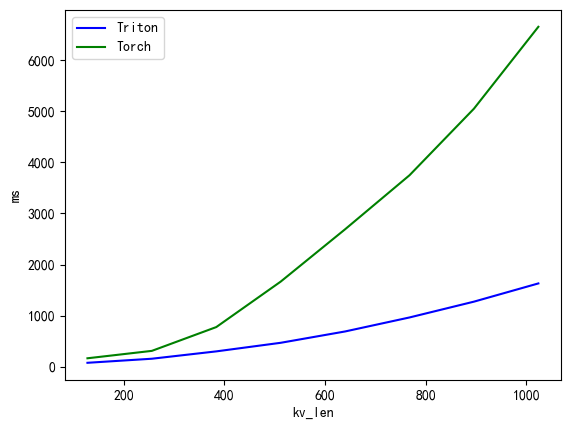

q_len = kv_len: prefill:
   kv_len       Triton        Torch
0   128.0    75.983420   164.442390
1   256.0   155.660048   309.486747
2   384.0   299.459577   775.281012
3   512.0   467.520714  1665.383935
4   640.0   689.472795  2690.070152
5   768.0   963.633478  3747.799635
6   896.0  1273.005009  5050.609112
7  1024.0  1629.769921  6653.682709


In [3]:
device = torch.device('cuda')
dtype = torch.float16

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['kv_len'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 8+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="q_len = kv_len: prefill",  # name for the plot. Used also as a file name for saving the plot.
        args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
              'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(kv_len, provider, bs, num_head, rope_head_dim, nope_head_dim, kv_lora_rank):
    q_len = kv_len
    v_head_dim = nope_head_dim
    scale = (rope_head_dim + nope_head_dim) ** (-0.5)
    qk_merge = torch.randn(bs,num_head,q_len,kv_lora_rank).to(dtype).to(device)
    compress_kv = torch.randn(bs,kv_len,kv_lora_rank).to(dtype).to(device)
    v = torch.nn.Linear(kv_lora_rank, num_head*v_head_dim).to(qk_merge.device).to(qk_merge.dtype)
    q_rope = torch.randn(bs,num_head,q_len,rope_head_dim).to(dtype).to(device)
    k_rope = torch.randn(bs,1,kv_len,rope_head_dim).to(dtype).to(device)

    
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch_mla(qk_merge, compress_kv, v.weight, q_rope, k_rope, scale, v_head_dim))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: triton_mla(qk_merge, compress_kv, v.weight, q_rope, k_rope, scale, v_head_dim))
    return ms * 1e3

benchmark.run(show_plots=True, print_data=True)

# 误差测试

In [34]:
device = torch.device('cuda')
dtype = torch.bfloat16
bs,num_head,q_len,kv_len, rope_head_dim,nope_head_dim=8,8,256,256, 32, 64
kv_lora_rank = 256
scale = (rope_head_dim + nope_head_dim) ** (-0.5)
qk_merge = torch.randn(bs,num_head,q_len,kv_lora_rank).to(dtype).to(device)
compress_kv = torch.randn(bs,kv_len,kv_lora_rank).to(dtype).to(device)
v = torch.nn.Linear(kv_lora_rank, num_head*nope_head_dim).to(qk_merge.device).to(qk_merge.dtype)
q_rope = torch.randn(bs,num_head,q_len,rope_head_dim).to(dtype).to(device)
k_rope = torch.randn(bs,1,kv_len,rope_head_dim).to(dtype).to(device)
mask = torch.ones(bs, kv_len, device=device, dtype=dtype)
padding = mask.shape[-1] - mask.sum(-1)
a = triton_mla(qk_merge, compress_kv, v.weight, q_rope, k_rope, scale, nope_head_dim, padding)
b = torch_mla(qk_merge, compress_kv, v.weight, q_rope, k_rope, scale, nope_head_dim, mask, golden=True).to(a.dtype)
print(torch.allclose(a, b, 0.001, 0.001))
print(torch.allclose(a, b, 0.005, 0.005))

False
True


In [4]:
device = torch.device('cuda')
dtype = torch.float16
bs,num_head,q_len,kv_len, rope_head_dim,nope_head_dim=8,8,256,256, 32, 64
kv_lora_rank = 256
scale = (rope_head_dim + nope_head_dim) ** (-0.5)
qk_merge = torch.randn(bs,num_head,q_len,kv_lora_rank).to(dtype).to(device)
compress_kv = torch.randn(bs,kv_len,kv_lora_rank).to(dtype).to(device)
v = torch.nn.Linear(kv_lora_rank, num_head*nope_head_dim).to(qk_merge.device).to(qk_merge.dtype)
q_rope = torch.randn(bs,num_head,q_len,rope_head_dim).to(dtype).to(device)
k_rope = torch.randn(bs,1,kv_len,rope_head_dim).to(dtype).to(device)
mask = torch.ones(bs, kv_len, device=device, dtype=dtype)
padding = mask.shape[-1] - mask.sum(-1)
a = triton_mla(qk_merge, compress_kv, v.weight, q_rope, k_rope, scale, nope_head_dim, padding)
b = torch_mla(qk_merge, compress_kv, v.weight, q_rope, k_rope, scale, nope_head_dim, mask, golden=True).to(a.dtype)
print(torch.allclose(a, b, 0.001, 0.001))
print(torch.allclose(a, b, 0.005, 0.005))

RuntimeError: Half did not match Float

# v_weight先乘还是后乘，复杂度对比

In [2]:
import math
import matplotlib.pyplot as plt
from functools import partial
import numpy as np

In [3]:
def func(N, v_head_dim, kv_lora_rank, BLOCK_M, BLOCK_N):
    steps = math.ceil(N/BLOCK_N)

    #1 先乘v_weight
    num_flops1 = (BLOCK_M * BLOCK_N * v_head_dim + BLOCK_N * kv_lora_rank * v_head_dim) * steps

    num_flops2 = (BLOCK_M * BLOCK_N * kv_lora_rank) * steps + BLOCK_M * kv_lora_rank * v_head_dim

    return num_flops1*2, num_flops2*2
new_func = partial(func, v_head_dim=64, kv_lora_rank=256, BLOCK_M=16, BLOCK_N=128)

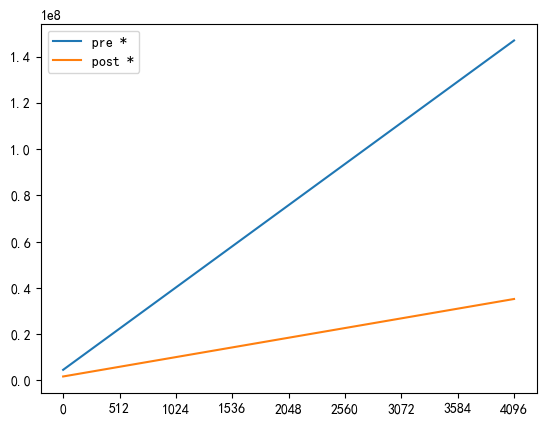

In [37]:
end = 33
data = np.array([new_func(i*128) for i in range(1, end+1)]).T
plt.plot(data[0])
plt.plot(data[1])
plt.xticks([i for i in range(0, end, 4)], [i*128 for i in range(0, end, 4)])
plt.legend(['pre * ', 'post *'])
plt.show()

In [5]:
a,b=new_func(512)
a/b

3.7777777777777777